In [59]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import pandas_datareader.data as web
import requests
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

comps = ['CCL', 'AAPL', 'GOOG', 'NFLX', 'AMZN', 'MGM', 'CVX', 'BAC', 'BA', 'DAL']

input_dim = 1
hidden_dim = 64
num_layers = 2
output_dim = 1
batch_size = 64
epochs = 20

window_size = 10
rate = .15

(MMM     0
 ABT     0
 ABMD    0
 ACN     0
 ATVI    0
        ..
 XLNX    0
 YUM     0
 ZBRA    0
 ZBH     0
 ZION    0
 Length: 448, dtype: int64,
 <AxesSubplot:>)

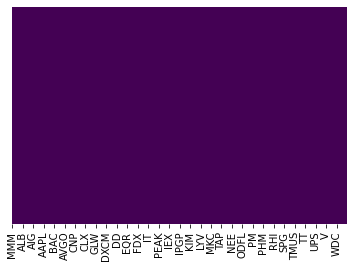

In [61]:
df = pd.read_csv('https://raw.githubusercontent.com/yuvalmargules/MI-LSTM/master/sp500_joined_closes.csv')
sp500 = pd.read_csv('https://raw.githubusercontent.com/yuvalmargules/MI-LSTM/master/sp500.csv')

sp500.set_index('Date', inplace=True)

sp500.rename(columns={'Adj Close': 'SP500'}, inplace=True)
sp500.drop(['Open', 'High', 'Low', 'Close', 'Volume'], 1, inplace=True)

df = df.dropna(axis=1)
df = df.drop('Date', axis=1)

df.isnull().sum(), sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [62]:
# Scaling
scaler = MinMaxScaler(feature_range=(-1,1))

names = df.columns
df_values = df.to_numpy()

df_values = np.array([scaler.fit_transform(col.reshape(-1, 1)) for col in df_values.T])
print(df_values.shape)

df_values = df_values.reshape(448,-1).T
print(df_values.shape)

df_norm = pd.DataFrame(df_values)
df_norm.columns = names

df_sp500 = pd.DataFrame(scaler.fit_transform(sp500))
df_sp500.columns = sp500.columns

df_norm.head(), df_sp500.head()

(448, 2812, 1)
(2812, 448)


(        MMM       ABT      ABMD       ACN      ATVI      ADBE       AMD  \
 0 -0.926278 -0.947719 -0.996153 -0.963914 -0.975621 -0.943652 -0.831015   
 1 -0.930583 -0.950639 -0.997103 -0.962147 -0.975243 -0.941265 -0.830806   
 2 -0.920897 -0.948648 -0.997692 -0.959089 -0.976377 -0.941578 -0.833734   
 3 -0.920400 -0.945661 -0.997692 -0.959361 -0.981479 -0.944435 -0.835826   
 4 -0.915516 -0.943802 -0.998461 -0.960516 -0.983180 -0.945217 -0.836662   
 
         AAP       AES       AFL  ...       WMB      WLTW      WYNN       XEL  \
 0 -0.985185 -0.666238 -0.734199  ... -0.882352 -0.986120 -0.975757 -0.977064   
 1 -0.988099 -0.676033 -0.709325  ... -0.875005 -0.987532 -0.946286 -0.982578   
 2 -0.983849 -0.685829 -0.701575  ... -0.855685 -0.977416 -0.953029 -0.981696   
 3 -0.983970 -0.685130 -0.692023  ... -0.860039 -0.979298 -0.942195 -0.983680   
 4 -0.982027 -0.658541 -0.701035  ... -0.855141 -0.980004 -0.945907 -0.983460   
 
         XRX      XLNX       YUM      ZBRA       ZBH  

In [63]:
class AttentionLayer(nn.Module):
    def __init__(self, hidden_size):
        super(AttentionLayer, self).__init__()

        self.W_b = nn.Linear(hidden_size, hidden_size)
        nn.init.xavier_normal_(self.W_b.weight)

        self.v_b = nn.Parameter(torch.nn.init.xavier_normal_(torch.zeros(1, hidden_size)))

    def forward(self, Y_tag):

        j = torch.tanh(self.W_b(Y_tag)) @ self.v_b.T
        return F.softmax(j, dim=1)


In [64]:
class MI_Cell(nn.Module):
    def __init__(self , input_size, hidden_size):
        super(MI_Cell, self).__init__()
        self.hidden_dim = hidden_size

        self.W_f = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_f.weight)

        self.W_o = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_o.weight)

        self.W_c = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_c.weight)
        # init with zero for filter auxilary data from related stocks w/o being biased
        self.W_cp = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.zeros_(self.W_cp.weight)
        nn.init.zeros_(self.W_cp.bias)
        # init with zero for filter auxilary data from related stocks w/o being biased
        self.W_cn = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.zeros_(self.W_cn.weight)
        nn.init.zeros_(self.W_cn.bias)
        # init with zero for filter auxilary data from related stocks w/o being biased
        self.W_ci = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.zeros_(self.W_ci.weight)
        nn.init.zeros_(self.W_ci.bias)

        self.W_i = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_i.weight)

        self.W_ip = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_ip.weight)

        self.W_in = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_in.weight)

        self.W_ii = nn.Linear(hidden_size + input_size, hidden_size)
        nn.init.xavier_normal_(self.W_ii.weight)

        self.W_a = nn.Linear(hidden_size, hidden_size)
        nn.init.xavier_normal_(self.W_a.weight)


    def forward(self, x, p, n, i, c_t_prev, h_t_prev):

        Y_tag = torch.zeros(x.size(0), 0, self.hidden_dim).to(device)

        for t in range(x.size(1)):

            x_t = torch.cat((h_t_prev, x[:, t].unsqueeze(2)), dim=1).view(x.size(0), 1, -1)
            p_t = torch.cat((h_t_prev, p[:, t].unsqueeze(2)), dim=1).view(p.size(0), 1, -1)
            n_t = torch.cat((h_t_prev, n[:, t].unsqueeze(2)), dim=1).view(n.size(0), 1, -1)
            i_t = torch.cat((h_t_prev, i[:, t].unsqueeze(2)), dim=1).view(i.size(0), 1, -1)

            f_t = torch.sigmoid(self.W_f(x_t))
            L_t, α = self.input_gate(x_t, p_t, n_t, i_t , c_t_prev)
            o_t = torch.sigmoid(self.W_o(x_t))

            c_t = c_t_prev * f_t + L_t
            h_t = torch.tanh(c_t * o_t)

            Y_tag = torch.cat((Y_tag, h_t), dim=1)

            h_t_prev = torch.transpose(h_t, 1, 2)
            c_t_prev = c_t
        # returns the output and the attention weights
        return Y_tag, α


    def input_gate(self, x, p, n, i, c_t_prev):

        c_t = torch.tanh(self.W_c(x))
        c_pt = torch.tanh(self.W_cp(p))
        c_nt = torch.tanh(self.W_cn(n))
        c_it = torch.tanh(self.W_ci(i))
        i_t = torch.sigmoid(self.W_i(x))

        i_pt = torch.sigmoid(self.W_ip(x))
        i_nt = torch.sigmoid(self.W_in(x))
        i_it = torch.sigmoid(self.W_ii(x))

        I_t = c_t * i_t
        I_pt = c_pt * i_pt
        I_nt = c_nt * i_nt
        I_it = c_it * i_it

        u_t = torch.tanh((self.W_a(c_t_prev) @ torch.transpose(I_t, 1, 2)))
        u_pt = torch.tanh((self.W_a(c_t_prev) @ torch.transpose(I_pt, 1, 2)))
        u_nt = torch.tanh((self.W_a(c_t_prev) @ torch.transpose(I_nt, 1, 2)))
        u_it = torch.tanh((self.W_a(c_t_prev) @ torch.transpose(I_it, 1, 2)))

        α = F.softmax(torch.cat((u_t, u_it, u_nt, u_pt), dim=1), dim=1)
        α_t, α_pt, α_nt, α_it = α[:,0].unsqueeze(2), α[:,1].unsqueeze(2), α[:,2].unsqueeze(2), α[:,3].unsqueeze(2)

        return [α_t * I_t + I_pt * α_pt + I_nt * α_nt + I_it * α_it, α]


In [65]:
class LSTMLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers):
        super(LSTMLayer, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        return out


In [66]:
class MI_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MI_LSTM, self).__init__()

        self.hidden_dim = hidden_size

        self.lstm = LSTMLayer(1, hidden_size, 1)
        self.multi_input_lstm = MI_Cell(hidden_size, hidden_size)
        self.attention_layer = AttentionLayer(hidden_size)

        self.fc1 = nn.Linear(hidden_size, hidden_size)
        nn.init.xavier_normal_(self.fc1.weight)

        self.fc2 = nn.Linear(hidden_size, output_size)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, x, p, n, i):
        c_t_prev = torch.zeros(x.size(0), 1, self.hidden_dim).requires_grad_().to(device)
        h_t_prev = torch.zeros(x.size(0), self.hidden_dim, 1).requires_grad_().to(device)

        Y_input = self.lstm(x)
        P_input = self.train_pos_neg_avg(p, size=Y_input.size())
        N_input = self.train_pos_neg_avg(n, size=Y_input.size())
        I_input = self.lstm(i)

        Y_tag, α = self.multi_input_lstm(Y_input, P_input, N_input, I_input, c_t_prev, h_t_prev)

        β = self.attention_layer(Y_tag)
        y_tilda = torch.transpose(β,1 ,2) @ Y_tag

        fc1 = torch.tanh(self.fc1(y_tilda))
        y_t_next = self.fc2(fc1)
        return y_t_next.squeeze(dim=2), α

    def train_pos_neg_avg(self, related_stocks, size):
        avg = torch.zeros(size).to(device)
        for company in related_stocks:
            avg += self.lstm(company)

        return avg / related_stocks.size(0)

In [67]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):

        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, _ = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) # last output
        return out

In [68]:
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        out, _ = self.gru(x, (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out


In [69]:
def split_data(stock, window_size, rate):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []

    # create all possible sequences of length seq_len
    for i in range(len(data_raw) - window_size):
        data.append(data_raw[i: i + window_size])

    data = np.array(data)
    test_set_size = int(np.floor(rate * data.shape[0]))
    train_set_size = data.shape[0] - test_set_size

    x_train = data[:train_set_size,:-1]
    y_train = data[:train_set_size,-1]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1]

    x_train = torch.from_numpy(x_train).type(torch.Tensor)
    x_test = torch.from_numpy(x_test).type(torch.Tensor)
    y_train = torch.from_numpy(y_train).type(torch.Tensor)
    y_test = torch.from_numpy(y_test).type(torch.Tensor)

    return [x_train.to(device), y_train.to(device), x_test.to(device), y_test.to(device)]


In [70]:
def train(x_train, y_train, model, criterion, optimizer, epochs, device):

    epoch_loss = []
    for epoch in range(epochs):

        batches_loss = 0.
        for i, (inputs, labels) in enumerate(zip(x_train, y_train)):

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            batches_loss += loss.item()
            # if i % 25 == 0:
                # print(f'epoch: {epoch+1}/{epochs}, batch_loss: {loss.item():.5f}')
        # print(f'epoch: {epoch+1}\{epochs}, loss: {loss.item()}')

        epoch_loss.append(batches_loss)
        # print(f'company: {comp} epoch: {epoch+1}/{epochs}, epoch loss: {epoch_loss[-1]}')

    return epoch_loss

In [71]:
def train_MI(x, y, pos, neg, idx,
         model, criterion, optimizer, epochs, device):
    epoch_loss = []
    epoch_attentions = torch.zeros(0, x.size(0) * x.size(1), 4, 1).to(device)
    for epoch in range(epochs):
        attention_weights = torch.zeros(0, 4, 1).to(device)
        running_loss = 0.
        for i in range(x.size(0)):

            labels = y[i]

            optimizer.zero_grad()

            outputs, α = model(x[i], pos[:, i], neg[:, i], idx[i])
            attention_weights = torch.cat((attention_weights, α), dim=0)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # if i % 10 == 0:
            #     print(f'epoch: {epoch+1}/{epochs}, batch: {i+1}/{x.size(0)}, loss: {running_loss/(i+1):.5f}')

        epoch_attentions = torch.cat((epoch_attentions, attention_weights.unsqueeze(dim=0)))
        epoch_loss.append(running_loss)

    return epoch_loss, epoch_attentions


Company: CCL
Chosen number of highly correlated companies: 10
         Train MSE  Test MSE
LSTM-1    0.002232  0.011729
GRU-1     0.001231  0.004362
LSTM-2    0.003538  0.019249
GRU-2     0.001597  0.005581
MI-LSTM   0.005807  0.034630
Company: AAPL
Chosen number of highly correlated companies: 10
         Train MSE  Test MSE
LSTM-1    0.000273  0.122744
GRU-1     0.000776  0.030987
LSTM-2    0.000431  0.103276
GRU-2     0.000451  0.007985
MI-LSTM   0.001676  0.159607
Company: GOOG
Chosen number of highly correlated companies: 10
         Train MSE  Test MSE
LSTM-1    0.000439  0.023047
GRU-1     0.000380  0.011614
LSTM-2    0.000815  0.033137
GRU-2     0.000768  0.005892
MI-LSTM   0.001439  0.024568
Company: NFLX
Chosen number of highly correlated companies: 10
         Train MSE  Test MSE
LSTM-1    0.000697  0.016988
GRU-1     0.000545  0.007776
LSTM-2    0.001060  0.023611
GRU-2     0.001246  0.005359
MI-LSTM   0.001960  0.011926
Company: AMZN
Chosen number of highly correlated comp

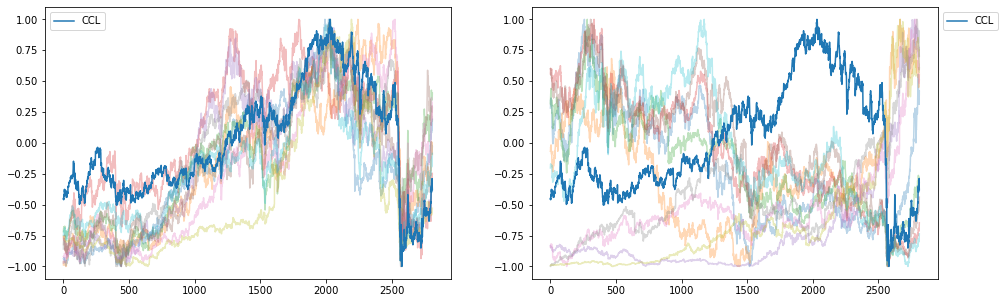

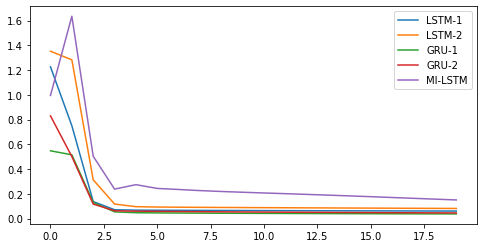

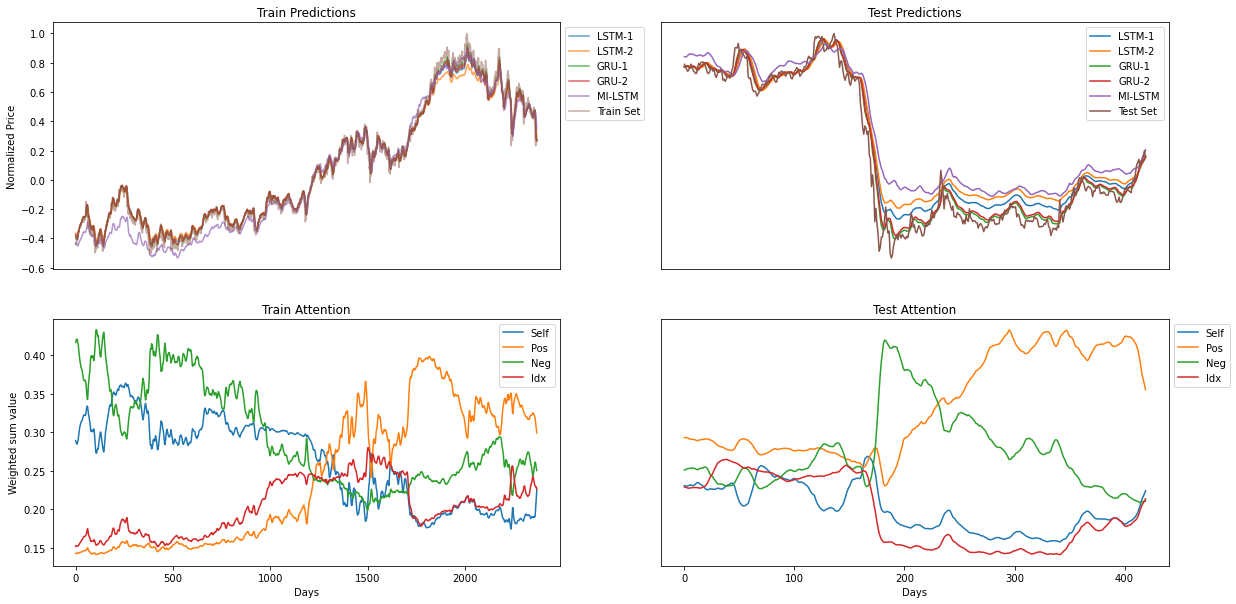

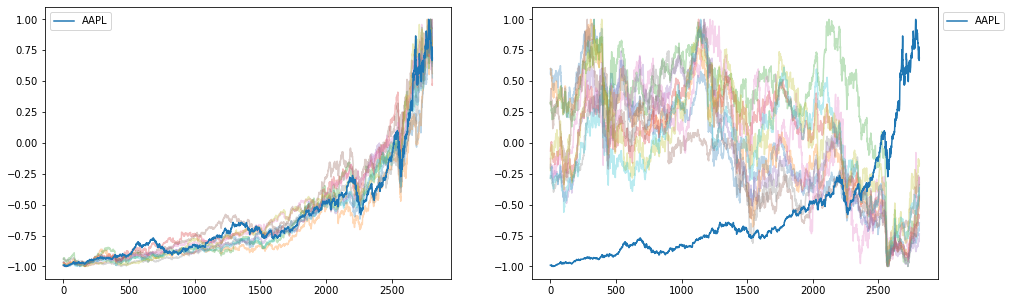

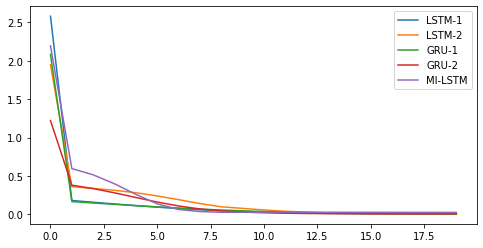

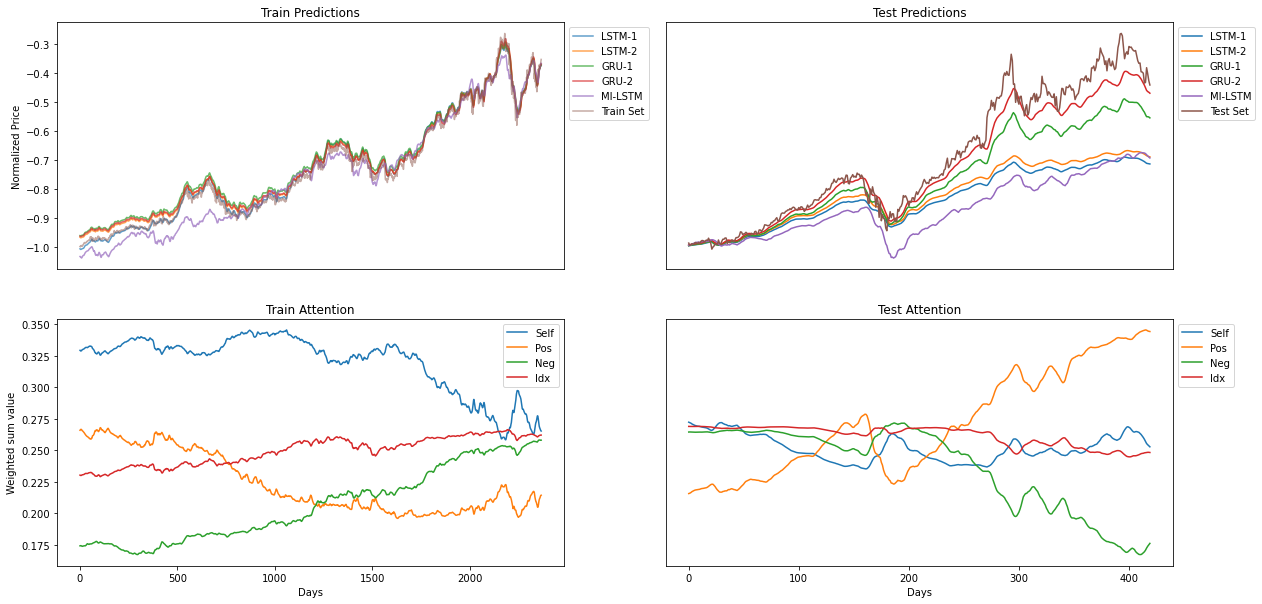

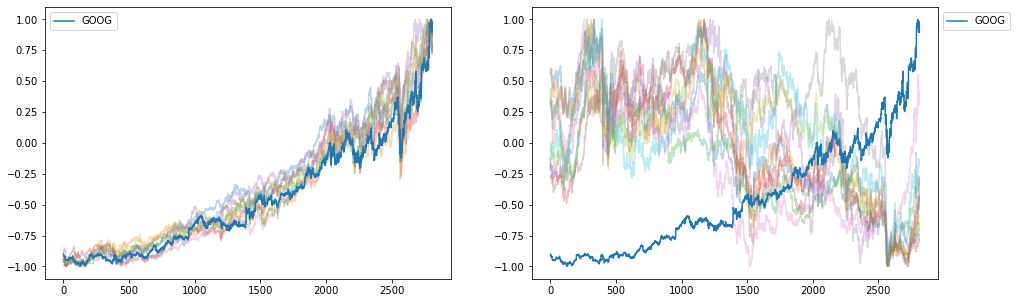

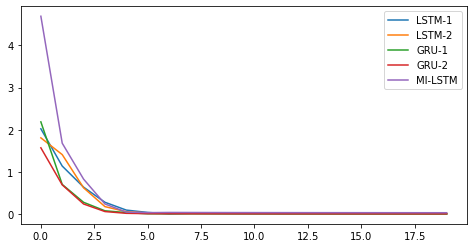

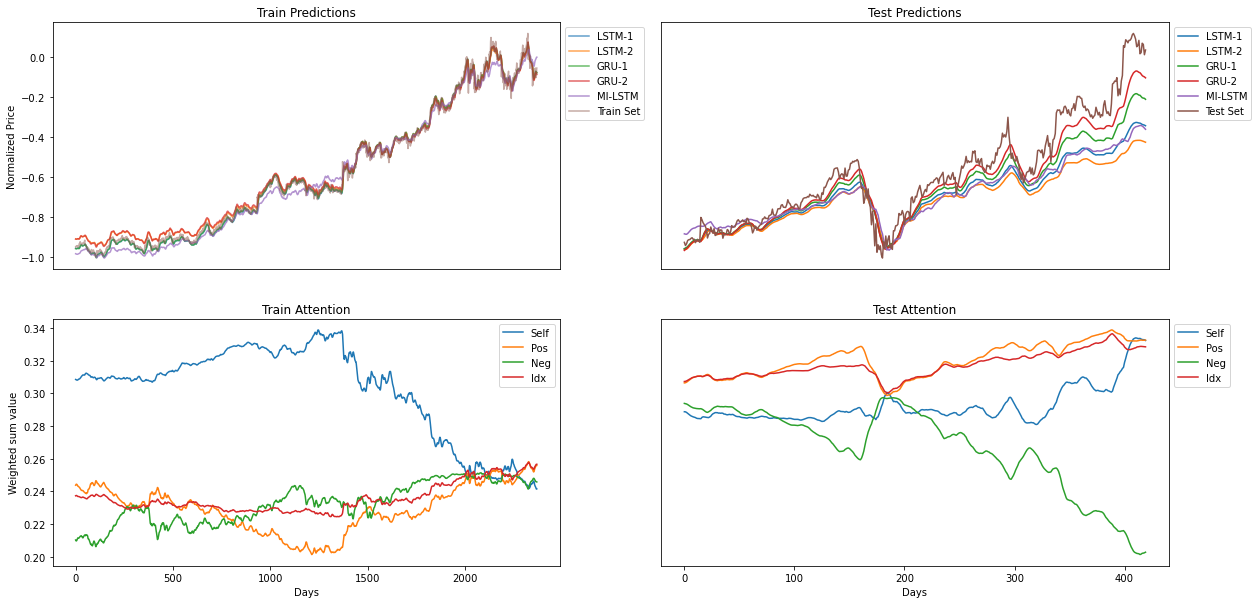

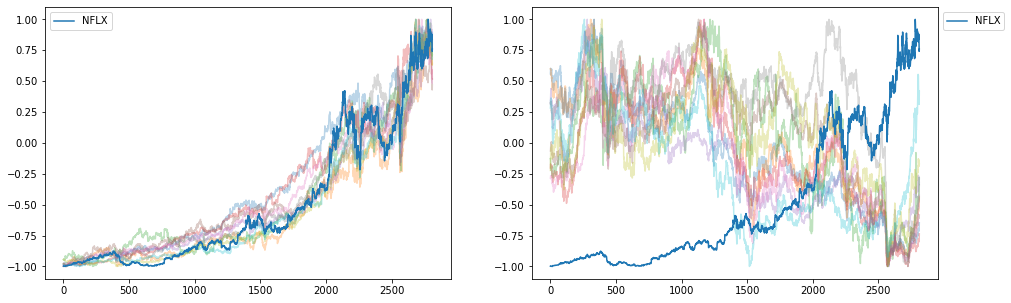

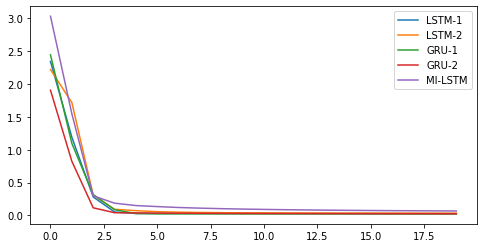

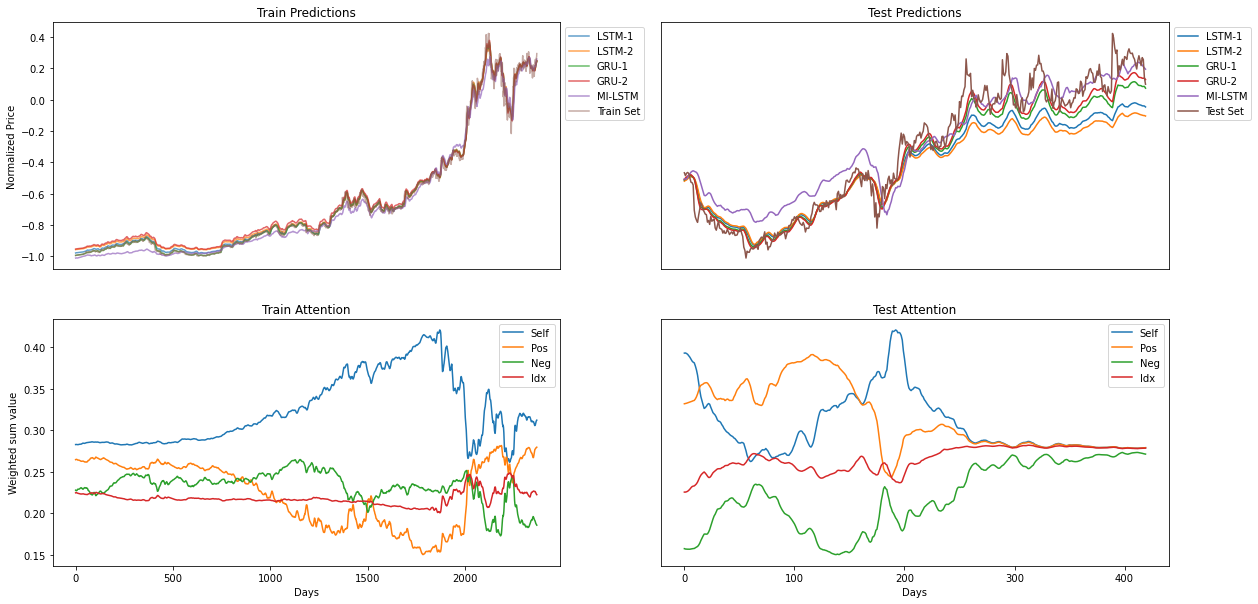

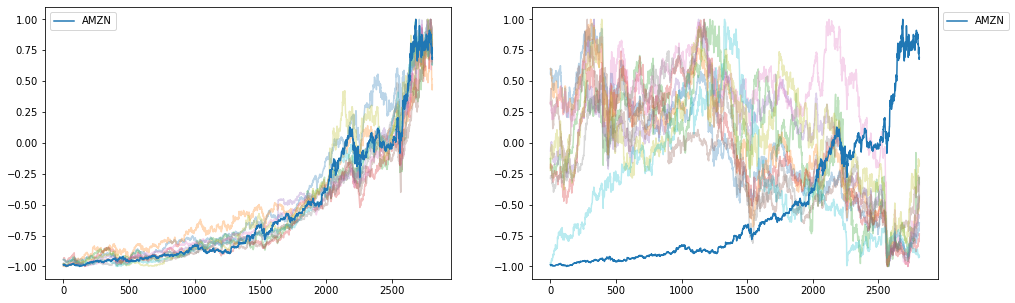

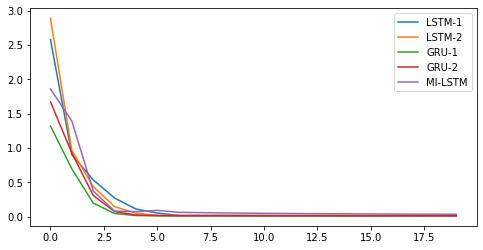

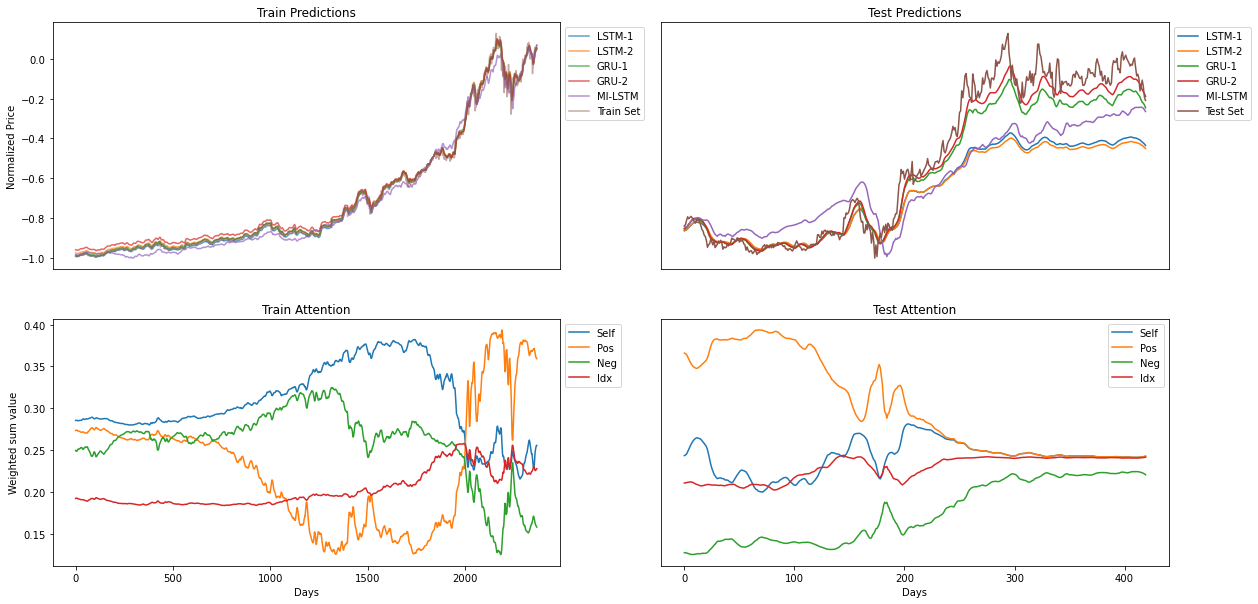

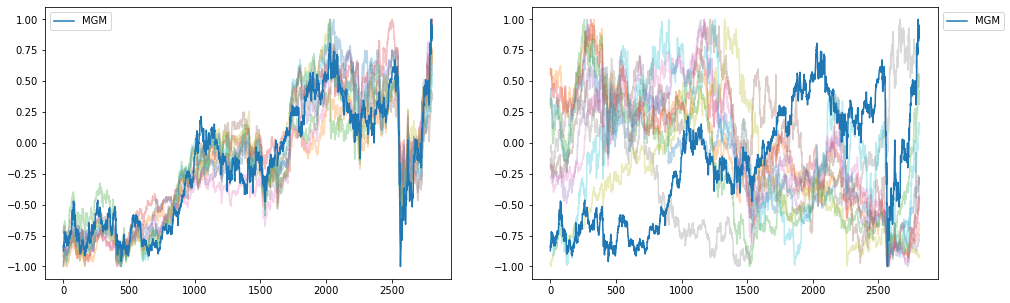

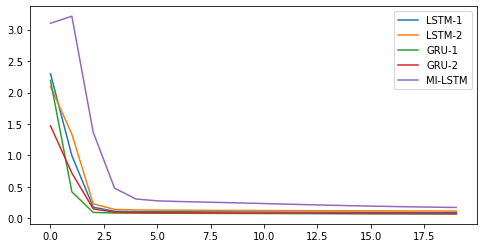

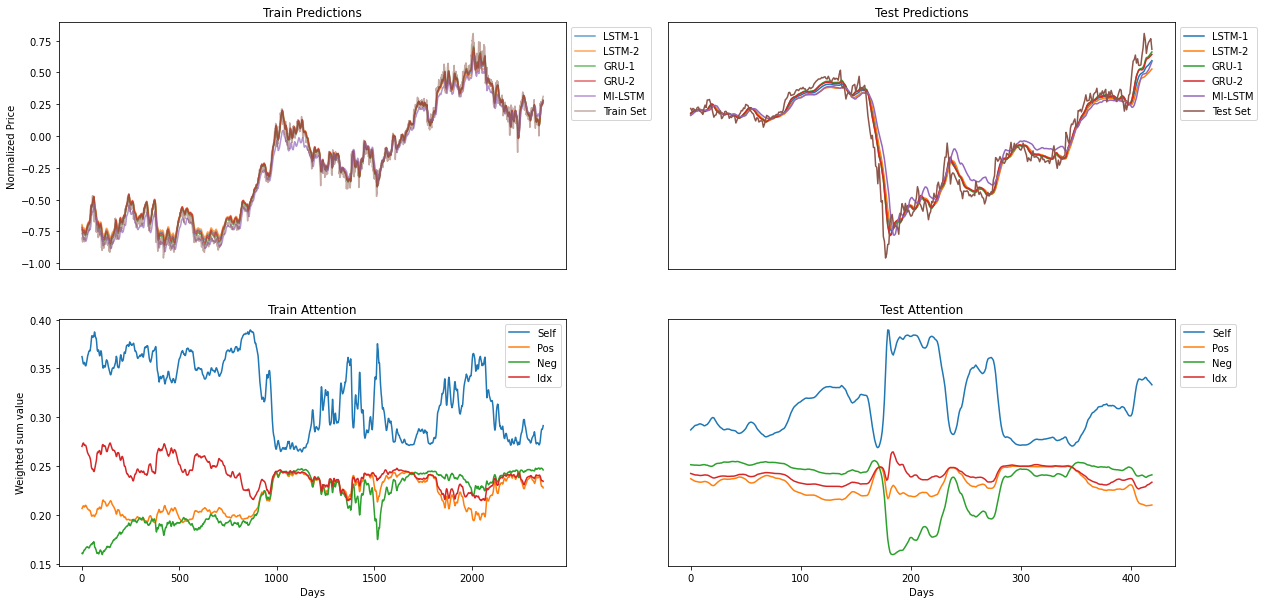

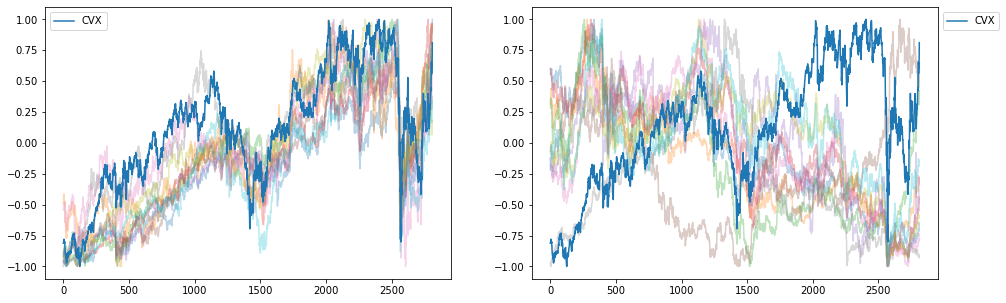

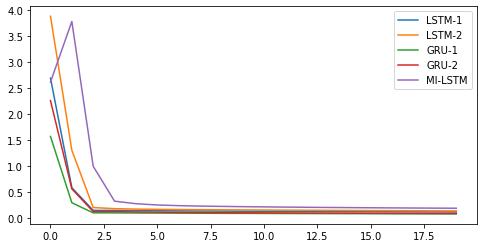

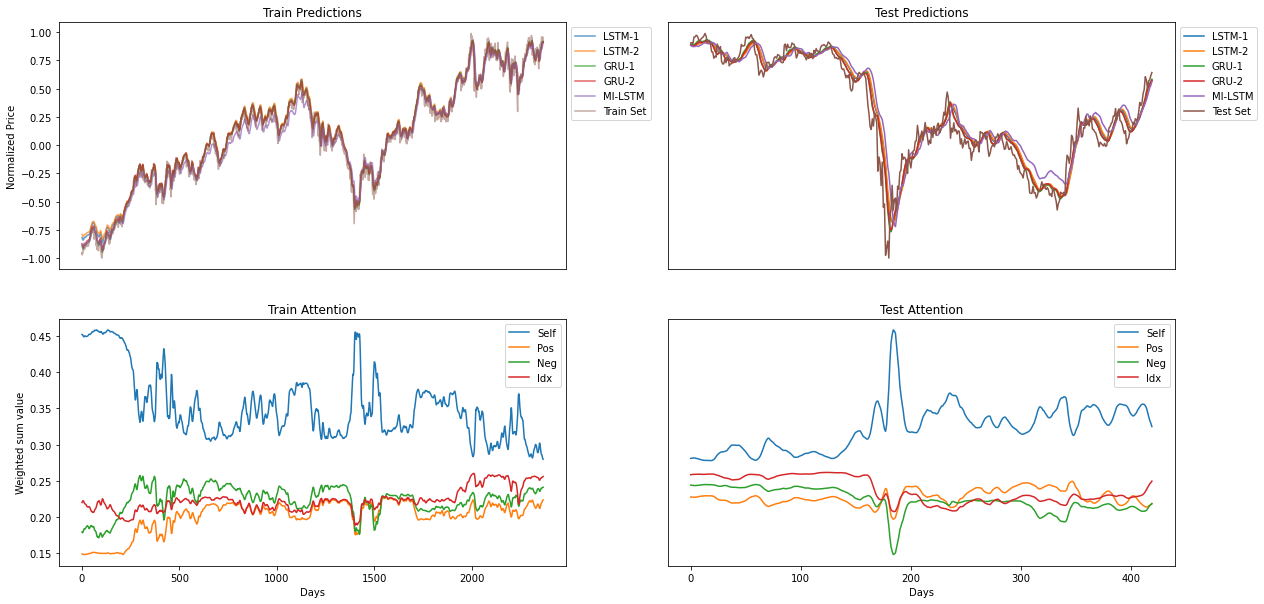

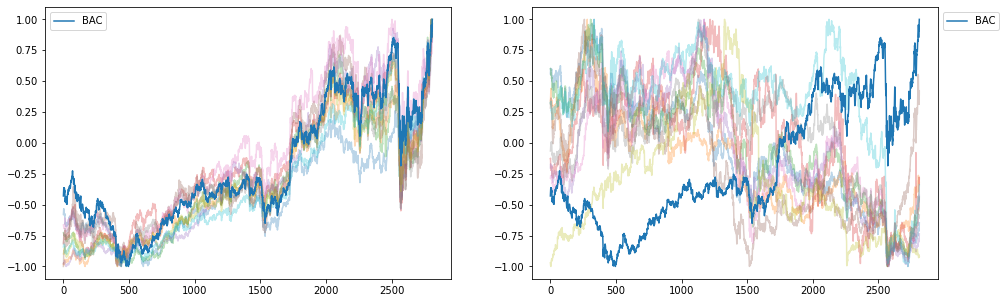

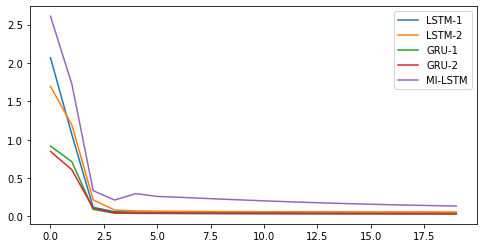

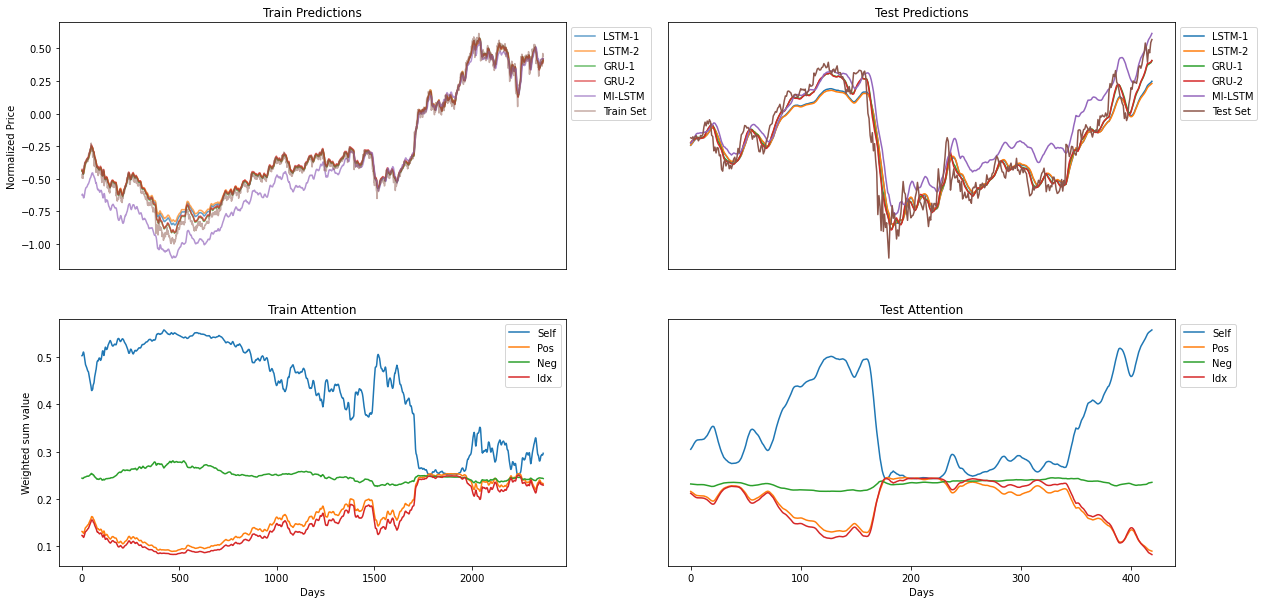

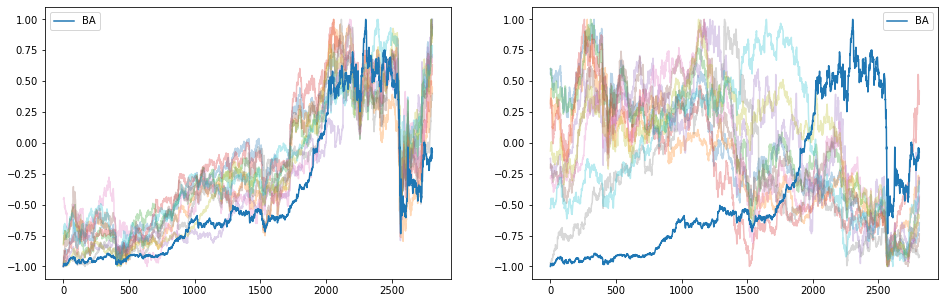

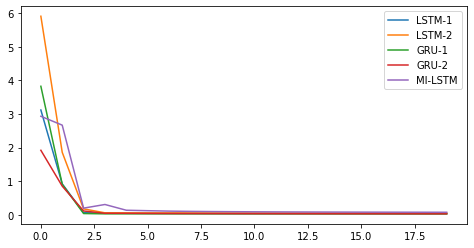

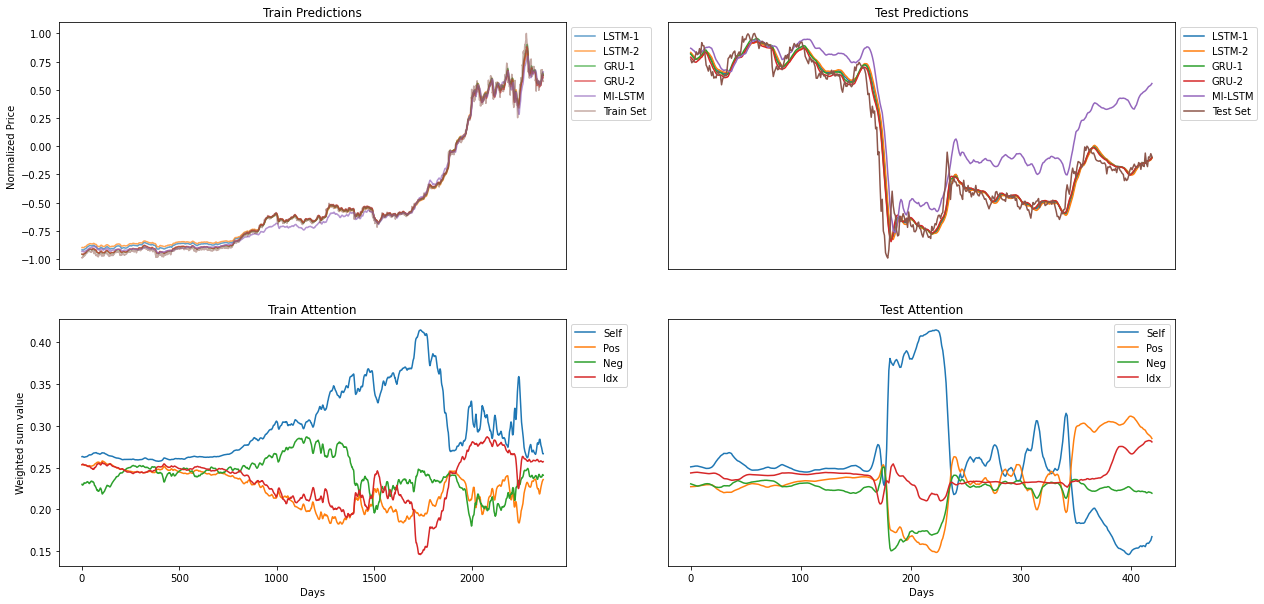

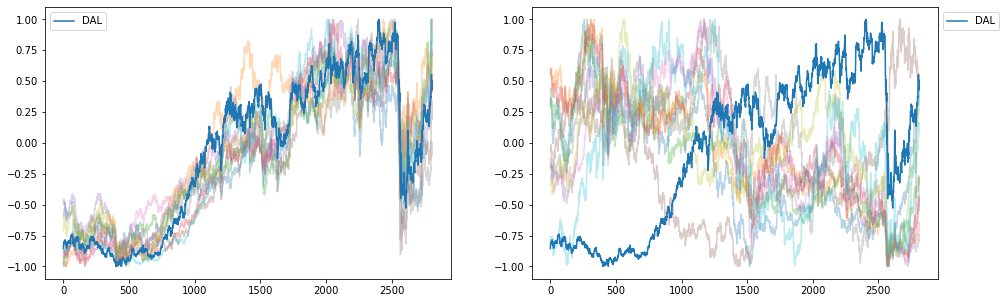

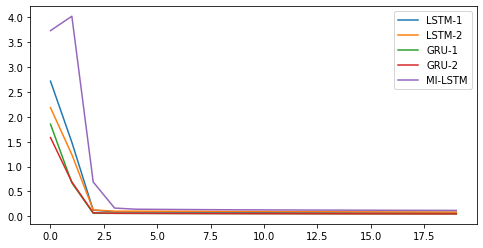

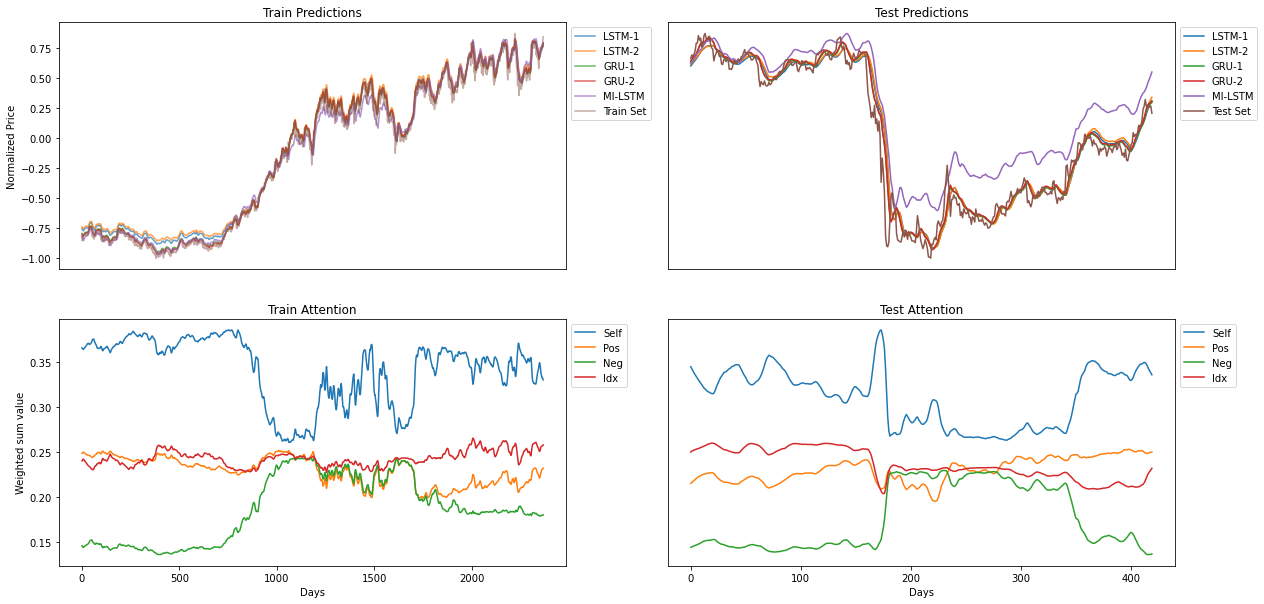

In [72]:
index = df_sp500 # normalized s&p500

for comp in comps:

    x = df_norm[comp] # normalized chosen company
    x_train, y_train, x_test, y_test = split_data(x, window_size, rate)

    head_trunc = x_train.size(0) % batch_size

    x_train = x_train[head_trunc:]
    x_train = x_train.view(x_train.size(0) // batch_size, batch_size, -1, 1)

    y_train = y_train[head_trunc:]
    y_train = y_train.view(y_train.size(0) // batch_size, batch_size, 1)


    index_train, _, index_test, _ = split_data(index, window_size, rate)

    head_trunc = index_train.size(0) % batch_size

    index_train = index_train[head_trunc:]
    index_train = index_train.view(index_train.size(0) // batch_size, batch_size, -1, 1)

    # sort by correlation
    pearson = df_norm.corr(method='pearson')
    pearson = pearson.sort_values(by=comp)[comp]

    n_companies = 10
    print(f'Company: {comp}')
    print(f'Chosen number of highly correlated companies: {n_companies}')

    pos = pearson[-(n_companies+1):-1]
    pos = df_norm[pos.index.values]
    # Top negative correlated
    neg = pearson[:n_companies]
    neg = df_norm[neg.index.values]


    fig, ax = plt.subplots(1,2, figsize=(16, 5))

    for company_p in pos.columns.to_numpy():
        ax[0].plot(pos[company_p], alpha=0.3)
    ax[0].plot(df_norm[comp], alpha=1, label=comp)

    for company_n in neg.columns.to_numpy():
        ax[1].plot(neg[company_n], alpha=0.3)
    ax[1].plot(df_norm[comp], alpha=1, label=comp)

    ax[0].legend()
    ax[1].legend(bbox_to_anchor=(1, 1))
    plt.show()

    # LSTM 1 Layer
    model_lstm1 = LSTM(input_dim, hidden_dim, 1, output_dim).to(device)
    criterion_lstm1 = nn.MSELoss()
    optimizer_lstm1 = torch.optim.Adagrad(model_lstm1.parameters())

    train_lstm1 = train(x_train, y_train, model_lstm1, criterion_lstm1, optimizer_lstm1, epochs, device)

    with torch.no_grad():
        outputs_lstm_train1 = model_lstm1(x_train.view(-1, x_train.size(2), 1))
        lstm_train_MSE1 = criterion_lstm1(outputs_lstm_train1, y_train.view(-1,1))

        outputs_lstm_test1 = model_lstm1(x_test.view(-1, x_train.size(2), 1))
        lstm_test_MSE1 = criterion_lstm1(outputs_lstm_test1, y_test.view(-1,1))


    # LSTM 2 layers
    model_lstm = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
    criterion_lstm = nn.MSELoss()
    optimizer_lstm = torch.optim.Adagrad(model_lstm.parameters())

    train_lstm = train(x_train, y_train, model_lstm, criterion_lstm, optimizer_lstm, epochs, device)

    with torch.no_grad():
        outputs_lstm_train = model_lstm(x_train.view(-1, x_train.size(2), 1))
        lstm_train_MSE = criterion_lstm(outputs_lstm_train, y_train.view(-1,1))


        outputs_lstm_test = model_lstm(x_test.view(-1, x_train.size(2), 1))
        lstm_test_MSE = criterion_lstm(outputs_lstm_test, y_test.view(-1,1))


    # GRU 1 Layer
    model_gru1 = GRU(input_dim, hidden_dim, 1, output_dim).to(device)
    criterion_gru1 = nn.MSELoss()
    optimizer_gru1 = torch.optim.Adagrad(model_gru1.parameters())

    train_gru1 = train(x_train, y_train, model_gru1, criterion_gru1, optimizer_gru1, epochs, device)

    with torch.no_grad():
        outputs_gru_train1 = model_gru1(x_train.view(-1, x_train.size(2), 1))
        gru_train_MSE1 = criterion_gru1(outputs_gru_train1, y_train.view(-1,1))

        outputs_gru_test1 = model_gru1(x_test.view(-1, x_train.size(2), 1))
        gru_test_MSE1 = criterion_gru1(outputs_gru_test1, y_test.view(-1,1))


    # GRU 2 Layers
    model_gru = GRU(input_dim, hidden_dim, num_layers, output_dim).to(device)
    criterion_gru = nn.MSELoss()
    optimizer_gru = torch.optim.Adagrad(model_gru.parameters())

    train_gru = train(x_train, y_train, model_gru, criterion_gru, optimizer_gru, epochs, device)

    with torch.no_grad():
        outputs_gru_train = model_gru(x_train.view(-1, x_train.size(2), 1))
        gru_train_MSE = criterion_gru(outputs_gru_train, y_train.view(-1,1))

        outputs_gru_test = model_gru(x_test.view(-1, x_train.size(2), 1))
        gru_test_MSE = criterion_gru(outputs_gru_test, y_test.view(-1,1))


    # MI-LSTM

    p_tensors_train = torch.zeros(0, x_train.size(0), x_train.size(1), x_train.size(2), 1).to(device)
    p_tensors_test = torch.zeros(0, x_test.size(0), x_test.size(1), 1).to(device)
    for i, col in enumerate(pos.columns):
        p_i = pd.DataFrame(pos[col])

        p_train, p_y, p_test, _ = split_data(p_i, window_size, rate)

        head_trunc = p_train.size(0) % batch_size

        p_train = p_train[head_trunc:]
        p_train = p_train.view(p_train.size(0) // batch_size, batch_size, -1, 1)

        p_tensors_train = torch.cat((p_tensors_train, p_train.unsqueeze(dim=0)))
        p_tensors_test = torch.cat((p_tensors_test, p_test.unsqueeze(dim=0)))

    n_tensors_train = torch.zeros(0, x_train.size(0), x_train.size(1), x_train.size(2), 1).to(device)
    n_tensors_test = torch.zeros(0, x_test.size(0), x_test.size(1), 1).to(device)
    for i, col in enumerate(neg.columns):
        n_i = pd.DataFrame(neg[col])

        n_train, n_y, n_test, _ = split_data(n_i, window_size, rate)

        head_trunc = n_train.size(0) % batch_size

        n_train = n_train[head_trunc:]
        n_train = n_train.view(n_train.size(0) // batch_size, batch_size, -1, 1)

        n_tensors_train = torch.cat((n_tensors_train, n_train.unsqueeze(dim=0)))
        n_tensors_test = torch.cat((n_tensors_test, n_test.unsqueeze(dim=0)))


    model_MI = MI_LSTM(hidden_dim, hidden_dim, output_dim).to(device)
    criterion_MI = nn.MSELoss()
    optimizer_MI = torch.optim.Adagrad(model_MI.parameters())

    train_mi, _ = train_MI(x_train, y_train, p_tensors_train, n_tensors_train, index_train,
                            model_MI, criterion_MI, optimizer_MI, epochs, device)

    with torch.no_grad():

        self_test = x_test.unsqueeze(2).to(device)

        mi_lstm_train, attention_train = model_MI(x_train.view(-1, x_train.size(2), 1), p_tensors_train.view(n_companies, -1, x_train.size(2), 1),
                              n_tensors_train.view(n_companies, -1, x_train.size(2), 1), index_train.view(-1, x_train.size(2), 1))
        mi_train_MSE = criterion_MI(mi_lstm_train, y_train.view(-1,1))

        mi_lstm_test, attention_test = model_MI(self_test, p_tensors_test, n_tensors_test, index_test)
        mi_test_MSE = criterion_MI(mi_lstm_test, y_test.view(-1,1))


    results_MSE = pd.DataFrame({'Train MSE': [lstm_train_MSE1.item(), gru_train_MSE1.item(), lstm_train_MSE.item(), gru_train_MSE.item(), mi_train_MSE.item()],
                  'Test MSE': [lstm_test_MSE1.item(), gru_test_MSE1.item(), lstm_test_MSE.item(), gru_test_MSE.item(), mi_test_MSE.item()]})
    results_MSE.index = ['LSTM-1', 'GRU-1', 'LSTM-2', 'GRU-2', 'MI-LSTM']

    print(results_MSE)


    plt.figure(figsize=(8,4))

    plt.plot(train_lstm1, label='LSTM-1')
    plt.plot(train_lstm, label='LSTM-2')
    plt.plot(train_gru1, label='GRU-1')
    plt.plot(train_gru, label='GRU-2')
    plt.plot(train_mi, label='MI-LSTM')

    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()


    fig, ax = plt.subplots(2,2, figsize=(20, 10))

    ax[0][0].plot(outputs_lstm_train1.to('cpu'), alpha=0.7, label='LSTM-1')
    ax[0][0].plot(outputs_lstm_train.to('cpu'), alpha=0.7, label='LSTM-2')
    ax[0][0].plot(outputs_gru_train1.to('cpu'), alpha=0.7, label='GRU-1')
    ax[0][0].plot(outputs_gru_train.to('cpu'), alpha=0.7, label='GRU-2')
    ax[0][0].plot(mi_lstm_train.to('cpu'), alpha=0.7, label='MI-LSTM')
    ax[0][0].plot(y_train.view(-1,1).to('cpu'), alpha=0.5, label='Train Set')

    ax[0][0].set(title='Train Predictions', ylabel = 'Normalized Price', xticks=([]))
    ax[0][0].legend(bbox_to_anchor=(1, 1))


    ax[0][1].plot(outputs_lstm_test1.to('cpu'), label='LSTM-1')
    ax[0][1].plot(outputs_lstm_test.to('cpu'), label='LSTM-2')
    ax[0][1].plot(outputs_gru_test1.to('cpu'), label='GRU-1')
    ax[0][1].plot(outputs_gru_test.to('cpu'), label='GRU-2')
    ax[0][1].plot(mi_lstm_test.to('cpu'), label='MI-LSTM')
    ax[0][1].plot(y_test.view(-1,1).to('cpu'), label='Test Set')

    ax[0][1].set(title='Test Predictions', xticks=([]), yticks=([]))
    ax[0][1].legend(bbox_to_anchor=(1, 1))


    att_self = attention_train[:,0].to('cpu')
    att_pos = attention_train[:,1].to('cpu')
    att_neg = attention_train[:,2].to('cpu')
    att_idx = attention_train[:,3].to('cpu')

    ax[1][0].plot(att_self.detach().numpy(), label='Self')
    ax[1][0].plot(att_pos.detach().numpy(), label='Pos')
    ax[1][0].plot(att_neg.detach().numpy(), label='Neg')
    ax[1][0].plot(att_idx.detach().numpy(), label='Idx')

    ax[1][0].set(title='Train Attention', xlabel='Days', ylabel = 'Weighted sum value')
    ax[1][0].legend(bbox_to_anchor=(1, 1))


    att_self_test = attention_test[:,0].to('cpu')
    att_pos_test = attention_test[:,1].to('cpu')
    att_neg_test = attention_test[:,2].to('cpu')
    att_idx_test = attention_test[:,3].to('cpu')

    ax[1][1].plot(att_self_test.detach().numpy(), label='Self')
    ax[1][1].plot(att_pos_test.detach().numpy(), label='Pos')
    ax[1][1].plot(att_neg_test.detach().numpy(), label='Neg')
    ax[1][1].plot(att_idx_test.detach().numpy(), label='Idx')

    ax[1][1].set(title='Test Attention', xlabel='Days', yticks=([]))
    plt.legend(bbox_to_anchor=(1, 1))


    plt.show()